# Analyse network

In this notebook, the shortest distance between every pair of cities on the Ticket to Ride map is calculated. 
To do this we employ [Dijkstra's algorithm](https://github.com/ahojukka5/Dijkstra/blob/master/dijkstra/dijkstra.py).

Using the shortest path information, we then calculate which connections are in the n shortest paths, and sum the number of paths going through each connection. 

This gives a heat map of the connections, showing how many routes are likely to go through them.

In [3]:
# setup modules
import os
import pandas as pd
import json
from collections import defaultdict
from pprint import pprint
import sys
import heapq
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

if os.path.basename(os.getcwd()) not in 'bin':
    raise EnvironmentError('Need to ensure that cwd is "bin"')

data_dir = os.path.join('..', 'data', 'USA')

In [26]:
# loading data and pre-processing
with open(os.path.join(data_dir, 'city_locations.json'), 'r') as city_file:
    city_dict = json.load(city_file)
    # keys = city names, values = [x_pos, y_pos]
cities = set(city_dict.keys())
n_cities = len(cities)

# [City A, City B, Distance, Color]
connections_df = pd.read_csv(os.path.join(data_dir, 'routes.csv'))
n_connections = len(connections_df.index)

connections = defaultdict(list)
# keys = cityA, values = (city_2)
for ind, city_A, city_B, dist, col in connections_df.itertuples():
    connections[city_A].append((city_B, dist))
    connections[city_B].append((city_A, dist))

## Find shortest distance between each pair of cities (Dijkstra's algorithm)

In [24]:
distances = dict()

for start in cities:
    distances[start] = dict()
    for city in cities:
        if city == start:
            distances[start][city] = 0
        else:
            distances[start][city] = sys.maxsize

    curr_city = start
    unvisited = distances[start].copy()

    while True:
        del unvisited[curr_city]

        for next_city, distance in connections[curr_city]:
            if next_city in unvisited:
                distances[start][next_city] = min(
                    distances[start][next_city],
                    distances[start][curr_city] + distance)
                unvisited[next_city] = distances[start][next_city]

        if len(unvisited) == 0:
            break

        curr_city = min(unvisited, key=unvisited.get)

## Find n shortest routes to satisfy each ticket

In [6]:
tickets_df = pd.read_csv(os.path.join(data_dir, 'tickets.csv'))

n_visited = [0 for _ in range(n_connections)]

for i_ticket, start, end, reward in tickets_df.itertuples():
    costs = defaultdict(set)
    for i_conn, city_A, city_B, dist, col in connections_df.itertuples():
        cost = min(distances[start][city_A] + distances[end][city_B],
                   distances[start][city_B] + distances[end][city_A]) + dist
        costs[cost].add(i_conn)
    
    n_include = 10
    cost_vals = heapq.nsmallest(n_include, costs.keys())
    
    for cost in cost_vals:
        for i_conn in costs[cost]:
            n_visited[i_conn] += 1
    
connections_li = connections_df.values.tolist()
sorted_connections = [connections_li[i] for i in np.argsort(n_visited)]
# pprint(sorted_connections)

## Plotting
Plot histogram and colormap showing number of routes going through each connection.

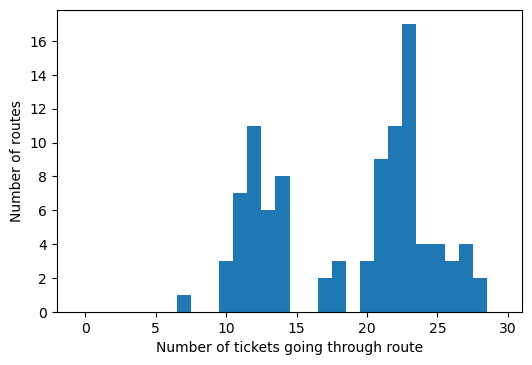

In [12]:
fig, ax = plt.subplots()
mpl.rcParams['figure.dpi'] = 100

ax.hist(n_visited, np.arange(-0.5, max(n_visited) + 0.5))
ax.set_xlabel('Number of tickets going through route')
ax.set_ylabel('Number of routes')
plt.savefig(os.path.join('..', 'plots',
                         'hist_{}_shortest.png'.format(n_include)))
plt.show()

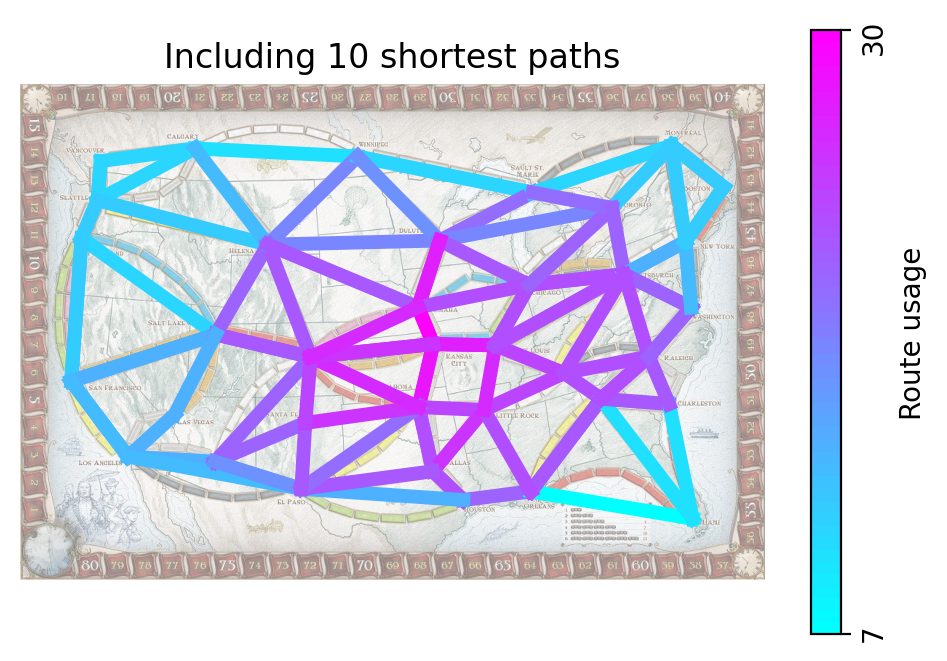

In [22]:
fig, ax = plt.subplots()
mpl.rcParams['figure.dpi'] = 200

# print map image
img = plt.imread(os.path.join('..', 'data', 'USA', 'USA_map.jpg'))
plt.imshow(img, alpha=0.5)
h, w, z = np.shape(img)
plt.axis('off')

min_visited = min(n_visited)
max_visited = max(n_visited)

cmap = plt.cm.get_cmap('cool', 50)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=[0, 1],
                    boundaries=np.linspace(0, 1, 100))
cbar.ax.set_yticklabels([str(min_visited), str(max_visited)],
                        rotation='vertical')
cbar.ax.set_ylabel(r'Route usage')

for ind, city_1, city_2, dist, col in connections_df.itertuples():
    x1, y1 = city_dict[city_1]
    x2, y2 = city_dict[city_2]
    col = cmap((n_visited[ind] - min_visited) / (max_visited - min_visited))
    plt.plot([x1*w, x2*w], [h - y1*h, h - y2*h],
             color=col, linewidth=5)

plt.title('Including {} shortest paths'.format(n_include))
plt.savefig(os.path.join('..', 'plots',
                         'heat_map_{}_shortest.png'.format(n_include)))

plt.show()